In [47]:
import dicom
from glob import glob
from os.path import join, basename
from IPython.display import clear_output
%pylab inline
from scipy.misc import imsave
gray();

In [18]:
folders = glob('/home/a.kondyukov/data/Indianapolis_sorted/*')
OUT = '/home/a.kondyukov/data/Indianapolis_prepared/'

patient from atherosclerosis #36


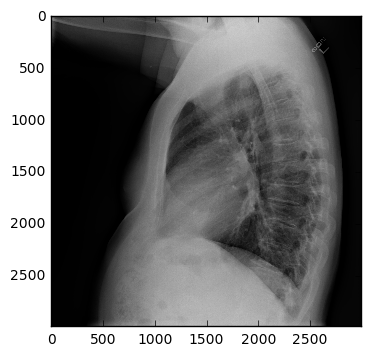

In [ ]:
tt = True
for fold in folders:
    files = glob(join(fold, '*'))
    i = 0
    for file in files:
        if tt and '/home/a.kondyukov/data/Indianapolis_sorted/atherosclerosis/2969_IM-1360-2001.dcm' not in file:
            continue
        tt = False
        clear_output()
        print("patient from %s #%d" % (basename(fold), i))
        try:
            lung = dicom.read_file(file).pixel_array
        except:
            continue
        imshow(lung)
        show()
        flag = int(input())
        if flag == 1:
            i+= flag
            imsave(join(OUT, 
                        basename(fold), 
                        ''.join(basename(file).split('.')[:-1]) + '.png'), 
                   lung, 'png')
        if i == 50:
            i = 0
            break
        